# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
sns.set_style('darkgrid')
import statsmodels.api as sm

from utils.preprocess import *
from utils.metrics import *

## Load and Examine Data

In [2]:
# List of selected tickers
assets = {
    "^GSPC": 'S&P', # S&P 500 Index
    #"000001.SS": 'SSE' # Shanghai Composite Index (SSE)
}

# Time period (from the paper)
start_date = "2009-05-01"
end_date = "2018-12-01"

# Fetching daily data
all_data = {}
for asset in assets:
    print(f"Downloading data for {asset}...")
    try:
        data = yf.download(asset, start=start_date, end=end_date, interval='1d')
        all_data[asset] = data[['Close']]
    except Exception as e:
        print(f"Could not download data for {asset}: {e}")

# Get prices and log returns
prices = pd.concat(all_data.values(), axis=1).dropna()
prices.columns = assets.values()
log_returns = np.log(prices).diff().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

In [3]:
print(prices.shape)

(2415, 1)


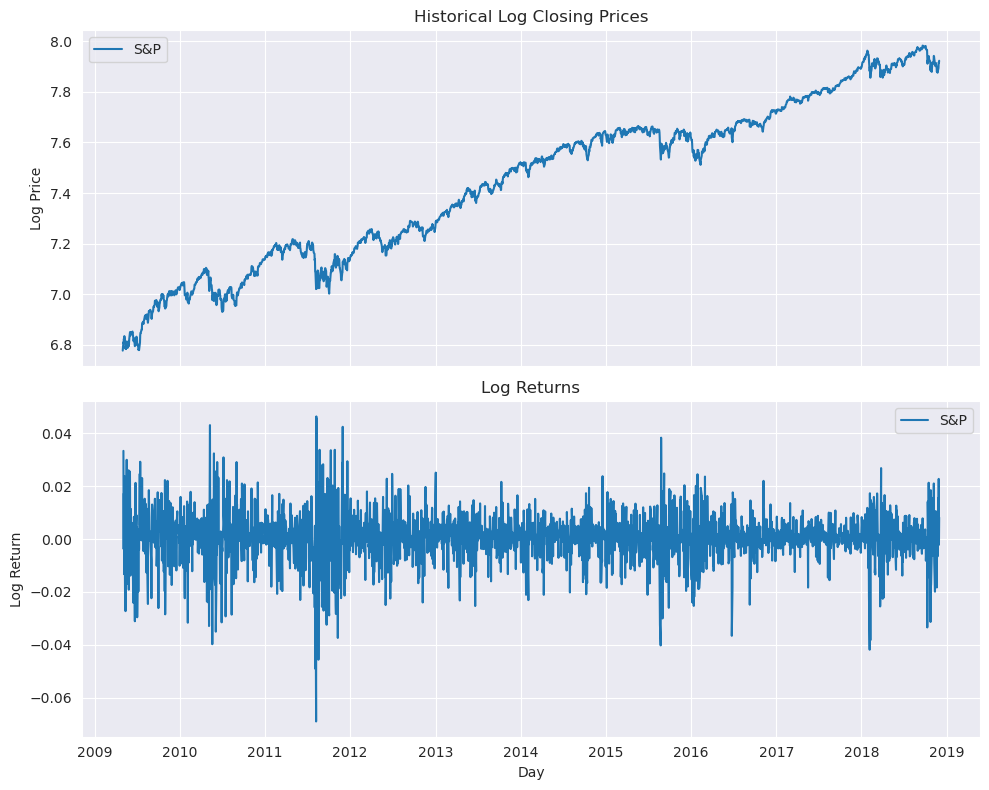

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot log prices
axs[0].plot(prices.index, np.log(prices), label=prices.columns)
axs[0].set_title('Historical Log Closing Prices')
axs[0].set_ylabel('Log Price')
axs[0].legend()
axs[0].grid(True)

# Plot log returns
axs[1].plot(log_returns.index, log_returns, label=prices.columns)
axs[1].set_title('Log Returns')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Log Return')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

Prior to passing a realization of a financial time series $s_{0:T} ∈ \mathbb{R}^{N_X×(T+1)}$ to the discriminator, the time series has to be preprocessed. The applied pipeline is displayed in Figure 9. We briefly explain each of the steps taken. Note that all of the used transformations, excluding the rolling window, are invertible and thus, allow a series sampled from a log return NP to be post-processed by inverting the steps 1-4 to obtain the desired form. Also, observe that the pipeline includes the inverse Lambert W
transformation as earlier discussed in subsection 5.3.

![Preprocessing Pipeline](preprocess/ScreenshotWiese_et_al.png)

## Step 1: Log returns $r_{1:T}$

Calculate the log return series
$$r_t = \log\biggl(\frac{s_t}{s_{t-1}}\biggr) \text { for all } t \in \{1, ..., T\}.$$

In [5]:
def compute_leverage_effect(log_returns: pd.Series, nlags : int = 100) -> pd.Series:
    volatility = log_returns ** 2
    corr_values = []
    for lag in range(1, nlags + 1):
        corr = np.corrcoef(log_returns.iloc[:-lag], volatility.iloc[lag:])[0, 1]
        corr_values.append(corr)
    return pd.Series(corr_values, index=range(1, nlags + 1))

In [6]:
# Calculate log returns and acf values
log_returns = np.log(prices).diff().dropna()
acf_serial, confint_serial = sm.tsa.stattools.acf(log_returns, nlags=100, alpha=0.05)
acf_squared, confint_squared = sm.tsa.stattools.acf(log_returns**2, nlags=100, alpha=0.05)
acf_abs, confint_abs = sm.tsa.stattools.acf(np.abs(log_returns), nlags=100, alpha=0.05)
leverage_effect = log_returns.apply(compute_leverage_effect)
lags = np.arange(len(acf_serial))

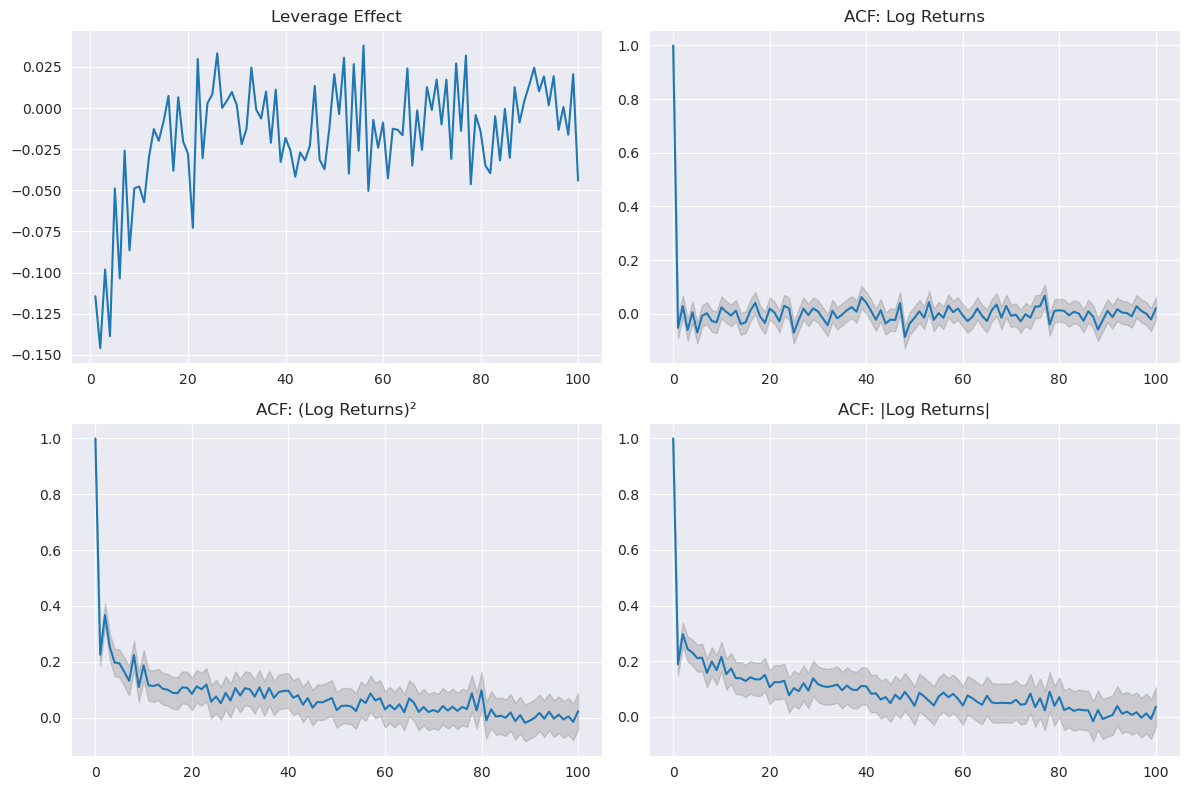

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# (1) Leverage effect
axs[0,0].plot(leverage_effect)
axs[0,0].set_title('Leverage Effect')
axs[0,0].grid(True)

# (2) ACF des rendements log
axs[0,1].plot(lags, acf_serial)
axs[0,1].fill_between(lags, confint_serial[:,0], confint_serial[:,1], color='gray', alpha=0.3)
axs[0,1].set_title('ACF: Log Returns')
axs[0,1].grid(True)

# (3) ACF des rendements log au carré
axs[1,0].plot(lags, acf_squared)
axs[1,0].fill_between(lags, confint_squared[:,0], confint_squared[:,1], color='gray', alpha=0.3)
axs[1,0].set_title('ACF: (Log Returns)²')
axs[1,0].grid(True)

# (4) ACF des rendements log absolus
axs[1,1].plot(lags, acf_abs)
axs[1,1].fill_between(lags, confint_abs[:,0], confint_abs[:,1], color='gray', alpha=0.3)
axs[1,1].set_title('ACF: |Log Returns|')
axs[1,1].grid(True)

plt.tight_layout()
plt.show()


## Step 2 & 4: Normalize
For numerical reasons, we normalize the data in order to obtain a series with zero mean and unit
variance, which is thoroughly derived in LeCun et al. (1998).

## Step 3: Inverse Lambert W transform
The suggested transformation applied to the log returns of the S&P 500 is displayed in Figure 10. It shows the standardized original distribution of the S&P 500 log returns and the inverse Lambert W transformed log return distribution. Observe that the transformed standardized log return distribution in Figure 10b approximately follows the standard normal distribution and thereby circumvents the issue of not being able to generate the heavy-tail of the original distribution.

## Step 5: Rolling window
When considering a discriminator with receptive field size $T^{(d)}$, we apply a rolling window of Corresponding length and stride one to the preprocessed log return sequence $r^{(ρ)}_t $. Hence, for $t∈\{1,...,T −T^{(d)}\}$ we define the sub-sequences
$$r^{(t)}_{1:T^{(d)}} := r^{(ρ)}_{t:(T^{(d)}+t−1)} ∈  \mathbb{R}^{N_Z×T^{(d)}}.$$

Remark 6.1. Note that sliding a rolling window introduces a bias, since log returns at the beginning
and end of the time series are under-sampled when training the Quant GAN. This bias can be corrected
by using a (non-uniform) weighted sampling scheme when sampling batches from the training set.

In [8]:
log_returns = np.log(prices).diff().dropna().values
log_norm = log_returns - np.mean(log_returns)
params = igmm(log_norm)
log_transformed = W_delta((log_norm - params[0]) / params[1], params[2])
log_max = np.max(np.abs(log_transformed))
log_processed = log_transformed / log_max

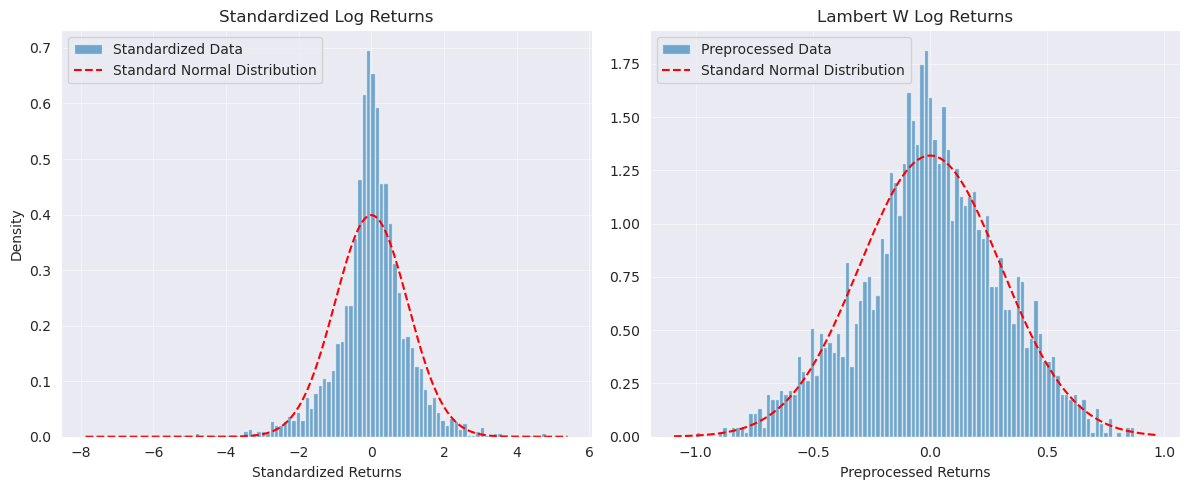

In [9]:
standardScaler = StandardScaler()
log_returns_scaled = standardScaler.fit_transform(log_returns)

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].hist(log_returns_scaled, bins=100, density=True, alpha=0.6, label='Standardized Data')
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed', color='r', label='Standard Normal Distribution')
ax[0].set_title('Standardized Log Returns')
ax[0].set_xlabel('Standardized Returns')
ax[0].set_ylabel('Density')
ax[0].legend()
ax[0].grid(True, alpha=0.5)

mu, sigma = log_processed.mean(), log_processed.std()
ax[1].hist(log_processed, bins=100, density=True, alpha=0.6, label='Preprocessed Data')
x_min, x_max = ax[1].get_xlim()
x_range = np.linspace(x_min, x_max, 1000)
ax[1].plot(x_range, norm.pdf(x_range, mu, sigma), linestyle='dashed', color='r',
           label='Standard Normal Distribution')
ax[1].set_title('Lambert W Log Returns')
ax[1].set_xlabel('Preprocessed Returns')
ax[1].legend()
ax[1].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()